In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import adjusted_mutual_info_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from icecream import ic
from tqdm.auto import tqdm

from utils.dataset import *
from utils.clustering import cluster_activations

In [3]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [4]:
seed_everything(42)

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
module_activation_dict = {
    # Conv blocks
    'audio_encoder.base.conv_block1': nn.Identity(),
    'audio_encoder.base.conv_block2': nn.Identity(),
    'audio_encoder.base.conv_block3': nn.Identity(),
    'audio_encoder.base.conv_block4': nn.Identity(),
    'audio_encoder.base.conv_block5': nn.Identity(),
    'audio_encoder.base.conv_block6': nn.Identity(),
    'audio_encoder.base.fc1': F.relu,
    'audio_encoder.projection.linear1': F.gelu,
    'audio_encoder.projection.linear2': nn.Identity(),
}

module_list = list(module_activation_dict.keys())

In [7]:
dataset = UrbanAcousticScenesDataset(class_limit=1000)

In [8]:
cluster_activations(dataset, module_list)

  0%|          | 0/9 [00:00<?, ?it/s]

Using PyNNDescent to compute 1st-neighbours at this step ...


/home2/pratyaksh.g/miniconda3/envs/ms-clap/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Step PyNNDescent done ...
Partition 0: 113755 clusters
Using PyNNDescent to compute 1st-neighbours at this step ...
Step PyNNDescent done ...
Partition 1: 10830 clusters
Partition 2: 1374 clusters
Partition 3: 239 clusters
Partition 4: 36 clusters
Partition 5: 5 clusters
Using PyNNDescent to compute 1st-neighbours at this step ...
Step PyNNDescent done ...
Partition 0: 63354 clusters
Partition 1: 6741 clusters
Partition 2: 945 clusters
Partition 3: 161 clusters
Partition 4: 16 clusters
Using PyNNDescent to compute 1st-neighbours at this step ...
Step PyNNDescent done ...
Partition 0: 31546 clusters
Partition 1: 2768 clusters
Partition 2: 422 clusters
Partition 3: 54 clusters
Partition 4: 4 clusters
Using PyNNDescent to compute 1st-neighbours at this step ...
Step PyNNDescent done ...
Partition 0: 18466 clusters
Partition 1: 1998 clusters
Partition 2: 417 clusters
Partition 3: 42 clusters
Partition 4: 4 clusters
Partition 0: 12629 clusters
Partition 1: 2577 clusters
Partition 2: 672 clu

# Minimal K-Clique on a complete K-partite graph

In [94]:
import itertools

def calculate_distance(node1, node2):
    # Define your distance metric here
    # For example, you can calculate Euclidean distance or any other metric
    # This function should return the distance between node1 and node2
    # For simplicity, let's assume nodes are represented as tuples of coordinates
    return abs(node1 - node2) / max(node1, node2)

def find_min_weight_k_clique(partition_nodes, k):
    min_weight = float('inf')
    min_clique = None

    for clique in tqdm(itertools.product(*partition_nodes), mininterval=1):
        if len(set(clique)) < k:
            continue

        for combination in itertools.combinations(clique, k):
            weight = sum(calculate_distance(node1, node2) for node1, node2 in itertools.combinations(combination, 2))
            if weight < min_weight:
                min_weight = weight
                min_clique = combination

    return min_clique, min_weight

## ESC-50

In [104]:
esc_n_clusters = []
for layer_name in module_list:
    esc_n_clust = torch.load(root + f'/esc50/clusters/{layer_name}_n.pt')
    esc_n_clusters.append([x.item() for x in esc_n_clust])
esc_n_clusters

[[142185, 21352, 4945, 1117, 225, 25, 3],
 [81942, 15435, 2803, 642, 134, 16, 3],
 [43404, 7542, 1243, 277, 40, 5],
 [24519, 4786, 1233, 203, 20, 5],
 [10530, 2590, 921, 62, 11],
 [24397, 5900, 1720, 178, 38, 5],
 [211, 31, 4],
 [142, 32, 13, 6, 3, 2],
 [176, 30, 7, 3, 2]]

In [110]:
partition_nodes = esc_n_clusters
k = len(esc_n_clusters)

min_clique, min_weight = find_min_weight_k_clique(partition_nodes, k)
print("Minimum weight k-clique:", min_clique)
print("Weight:", min_weight)

0it [00:00, ?it/s]

Minimum weight k-clique: (225, 134, 277, 203, 62, 178, 211, 142, 176)
Weight: 11.97775388441079


In [105]:
partition_nodes = esc_n_clusters[:-3]
k = len(esc_n_clusters[:-3])

min_clique, min_weight = find_min_weight_k_clique(partition_nodes, k)
print("Minimum weight k-clique:", min_clique)
print("Weight:", min_weight)

0it [00:00, ?it/s]

Minimum weight k-clique: (1117, 642, 1243, 1233, 921, 1720)
Weight: 4.58438399768087


In [109]:
partition_nodes = esc_n_clusters[-3:]
k = len(esc_n_clusters[-3:])

min_clique, min_weight = find_min_weight_k_clique(partition_nodes, k)
print("Minimum weight k-clique:", min_clique)
print("Weight:", min_weight)

0it [00:00, ?it/s]

Minimum weight k-clique: (31, 32, 30)
Weight: 0.12600806451612903


## Urban Acoustic Scenes

In [107]:
tau_n_clusters = []
for layer_name in module_list:
    tau_n_clust = torch.load(root + f'/urban-acoustic-scenes/clusters/{layer_name}_n.pt')
    tau_n_clusters.append([x.item() for x in tau_n_clust])
tau_n_clusters

[[113755, 10830, 1374, 239, 36, 5],
 [63354, 6741, 945, 161, 16],
 [31546, 2768, 422, 54, 4],
 [18466, 1998, 417, 42, 4],
 [12629, 2577, 672, 28, 5],
 [20636, 3794, 823, 86, 12, 3],
 [142, 22, 9, 7, 5, 3],
 [117, 14, 6, 3],
 [82, 14, 4]]

In [111]:
partition_nodes = tau_n_clusters
k = len(tau_n_clusters)

min_clique, min_weight = find_min_weight_k_clique(partition_nodes, k)
print("Minimum weight k-clique:", min_clique)
print("Weight:", min_weight)

0it [00:00, ?it/s]

Minimum weight k-clique: (36, 161, 54, 42, 28, 86, 142, 117, 82)
Weight: 17.38709238164305


In [112]:
partition_nodes = tau_n_clusters[:-3]
k = len(tau_n_clusters[:-3])

min_clique, min_weight = find_min_weight_k_clique(partition_nodes, k)
print("Minimum weight k-clique:", min_clique)
print("Weight:", min_weight)

0it [00:00, ?it/s]

Minimum weight k-clique: (1374, 945, 422, 417, 672, 823)
Weight: 6.071066306404186


In [113]:
partition_nodes = tau_n_clusters[-3:]
k = len(tau_n_clusters[-3:])

min_clique, min_weight = find_min_weight_k_clique(partition_nodes, k)
print("Minimum weight k-clique:", min_clique)
print("Weight:", min_weight)

0it [00:00, ?it/s]

Minimum weight k-clique: (5, 6, 4)
Weight: 0.7


## Adjusted Mutual Information

In [7]:
# Minimal k-cliques for CNNs and linear layers separately
esc_pt_indices = [3, 3, 2, 2, 2, 2] + [1, 1, 1]
tau_pt_indices = [2, 2, 2, 2, 2, 2] + [4, 2, 2]

In [8]:
root = '/scratch/pratyaksh.g/'
# ami = []
nmi = []
for layer_idx, layer_name in enumerate(module_list):
    esc = torch.load(root + f'esc50/clusters/{layer_name}.pt')
    esc_pt_idx = esc_pt_indices[layer_idx]
    esc_clust = esc[:, esc_pt_idx]

    tau = torch.load(root + f'urban-acoustic-scenes/clusters/{layer_name}.pt')
    tau_pt_idx = tau_pt_indices[layer_idx]
    tau_clust = tau[:, tau_pt_idx]

    # ami.append(adjusted_mutual_info_score(esc_clust, tau_clust))
    nmi.append(normalized_mutual_info_score(esc_clust, tau_clust))

In [10]:
nmi

[0.3266622194398932,
 0.3564831912750793,
 0.3028694612675639,
 0.41310174109002257,
 0.5537610192380596,
 0.5210281008633828,
 0.012647653309217372,
 0.06768005518832601,
 0.0491867340734742]

<AxesSubplot:>

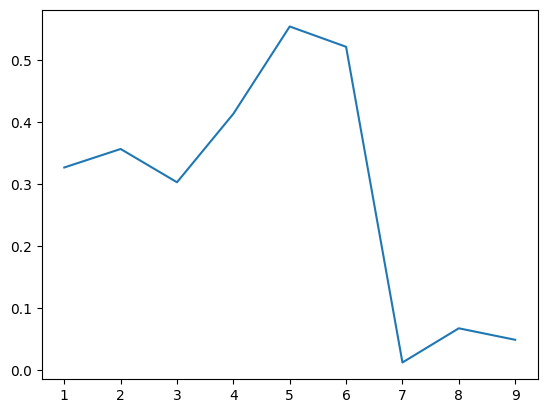

In [11]:
sns.lineplot(x=range(1, 10), y=nmi)